## Formula 1 placement predictions based on historical race data

Project for the Fundamentals of Machine Learning course.

The primary goal of this project is to predict the placement of drivers in a Formula 1 race based on historical race data. However, based on what other people have done in the past and based on my own intuition, I believe that predicting the exact placement is going to be quite inaccurate, so this project focuses on predicting whether a driver will finish in the top 3 (a podium finish) or not. After achieving this goal, I look into trying to predict the exact placement as a bonus.

Dancea Radu-Ioan

In [994]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

#### Loading the data

In [995]:
DATA_PATH = "data/"
YEAR_CUTOFF = 1980

results = pd.read_csv(DATA_PATH + "results.csv")
races = pd.read_csv(DATA_PATH + "races.csv")
qualifying = pd.read_csv(DATA_PATH + "qualifying.csv")

#### Preprocessing
There is a lot of information in the loaded files, a lot of which is not relevant to our objective. In the following cells these extra columns are eliminated and some extra features are added.

In [996]:
results = results[[
    "raceId",
    "driverId",
    "constructorId",
    "grid",
    "positionOrder"
]]

races = races[[
    "raceId",
    "year",
    "round",
]]

qualifying = qualifying[[
    "raceId",
    "driverId",
    "position"
]].rename(columns={"position": "qualifying_position"})

In [997]:
print(results.shape)
print(results.head())

print(races.shape)
print(races.head())

print(qualifying.shape)
print(qualifying.head())

(26759, 5)
   raceId  driverId  constructorId  grid  positionOrder
0      18         1              1     1              1
1      18         2              2     5              2
2      18         3              3     7              3
3      18         4              4    11              4
4      18         5              1     3              5
(1125, 3)
   raceId  year  round
0       1  2009      1
1       2  2009      2
2       3  2009      3
3       4  2009      4
4       5  2009      5
(10494, 3)
   raceId  driverId  qualifying_position
0      18         1                    1
1      18         9                    2
2      18         5                    3
3      18        13                    4
4      18         2                    5


The next cell adds the goal of this project: whether a driver will finish in the top 3 (1) or not (0)

In [998]:
results["top3"] = (results["positionOrder"] <= 3).astype(int)

The results are split across multiple dataframes, so we must merge them using the id columns

In [999]:
df = results.merge(races, on="raceId", how="left")
df = df.merge(
    qualifying,
    on=["raceId", "driverId"],
    how="left"
)

print(df.shape)
df.head()

(26759, 9)


,raceId,driverId,constructorId,grid,positionOrder,top3,year,round,qualifying_position
0,18,1,1,1,1,1,2008,1,1.0
1,18,2,2,5,2,1,2008,1,5.0
2,18,3,3,7,3,1,2008,1,7.0
3,18,4,4,11,4,0,2008,1,12.0
4,18,5,1,3,5,0,2008,1,3.0


In [1000]:
df = df[df["year"] >= YEAR_CUTOFF].copy()

#### Data visualization

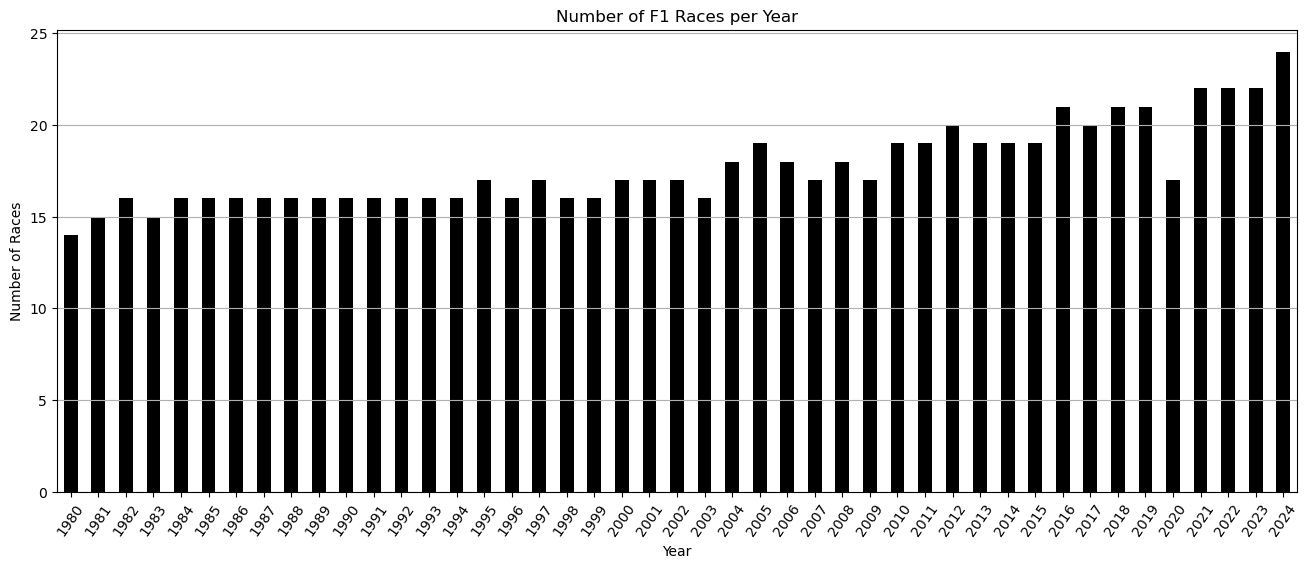

In [1001]:
# Number of races per year

races_per_year = df.groupby('year')['raceId'].nunique()

plt.figure(figsize=(16, 6))
races_per_year.plot(kind='bar', color='black')

plt.title('Number of F1 Races per Year')
plt.xlabel('Year')
plt.ylabel('Number of Races')
plt.xticks(rotation = 55)
plt.grid(axis='y')

plt.show()

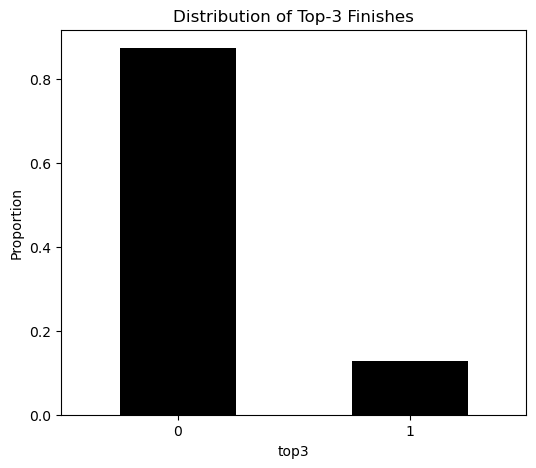

In [1002]:
# Class imbalance visualization: distribution of top 3 finishes

top3_counts = df["top3"].value_counts(normalize=True)

plt.figure(figsize=(6, 5))
top3_counts.plot(kind="bar", color="black")

plt.title("Distribution of Top-3 Finishes")
plt.ylabel("Proportion")
plt.xticks(rotation=0)

plt.show()

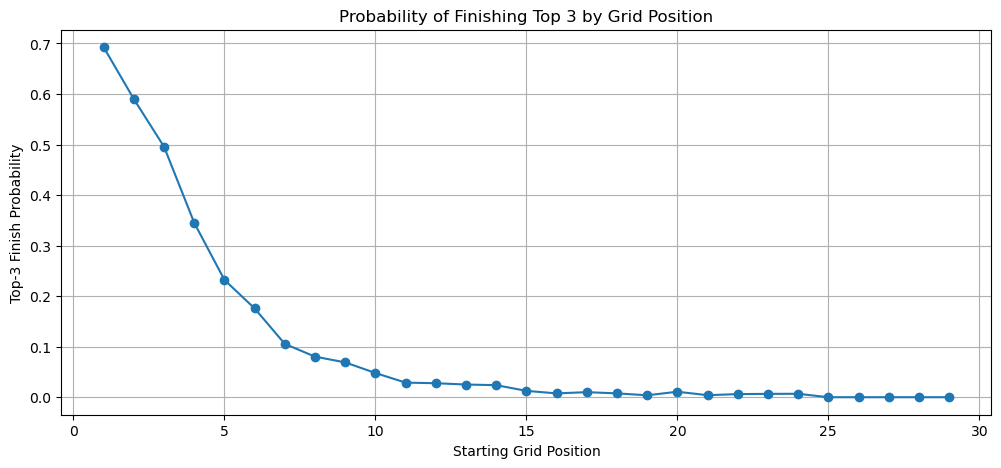

In [1003]:
# Probability of finishing in the top 3 based on the starting grid position.

grid_top3_rate = df.groupby("grid")["top3"].mean()

grid_zero_rate = grid_top3_rate.loc[0]
grid_normal = grid_top3_rate.loc[grid_top3_rate.index > 0]

plt.figure(figsize=(12, 5))
grid_normal.plot(kind="line", marker="o")

plt.title("Probability of Finishing Top 3 by Grid Position")
plt.xlabel("Starting Grid Position")
plt.ylabel("Top-3 Finish Probability")
plt.grid()

plt.show()

#### Extra features

The problem with the features we have so far is that they don't show the driver's evolution throughout a season. Previous races don't matter when predicting the result for the current race. In order to change this, we add a few features that represent the performance of the driver for the previous races in the season.

Average driver finish for the previous races in the season.

In [1004]:
df = df.sort_values(["year", "round"])

df["driver_avg_finish"] = (
    df.groupby(["year", "driverId"])["positionOrder"]
      .transform(lambda x: x.shift().expanding().mean())
)

# The average finish for Lewis Hamilton in 2019
grouped = df.groupby(["year", "driverId"])
print(grouped.get_group((2019, 1))[
    ["year", "round", "driverId", "positionOrder", "driver_avg_finish"]
])

print(df.shape)
df.tail(10)

       year  round  driverId  positionOrder  driver_avg_finish
24198  2019      1         1              2                NaN
24217  2019      2         1              1           2.000000
24237  2019      3         1              1           1.500000
24258  2019      4         1              2           1.333333
24277  2019      5         1              1           1.500000
24300  2019      6         1              1           1.400000
24320  2019      7         1              1           1.333333
24340  2019      8         1              1           1.285714
24364  2019      9         1              5           1.250000
24380  2019     10         1              1           1.666667
24408  2019     11         1              9           1.600000
24420  2019     12         1              1           2.272727
24441  2019     13         1              2           2.166667
24462  2019     14         1              3           2.153846
24483  2019     15         1              4           2

,raceId,driverId,constructorId,grid,positionOrder,top3,year,round,qualifying_position,driver_avg_finish
26749,1144,848,3,18,11,0,2024,24,16.0,14.695652
26750,1144,852,215,11,12,0,2024,24,11.0,13.217391
26751,1144,855,15,15,13,0,2024,24,17.0,15.608696
26752,1144,840,117,13,14,0,2024,24,13.0,13.347826
26753,1144,862,214,17,15,0,2024,24,20.0,NaN
26754,1144,825,210,14,16,0,2024,24,15.0,13.238095
26755,1144,859,215,12,17,0,2024,24,12.0,12.800000
26756,1144,822,15,9,18,0,2024,24,9.0,15.739130
26757,1144,861,3,20,19,0,2024,24,19.0,12.875000
26758,1144,815,9,10,20,0,2024,24,10.0,9.173913


Driver average finish in previous season

In [1005]:
prev_season = (
    df.groupby(["year", "driverId"])["positionOrder"]
      .mean()
      .reset_index()
)

prev_season["year"] += 1

df = df.merge(
    prev_season,
    on=["year", "driverId"],
    how="left",
    suffixes=("", "_prev_season_average")
)

Number of top 3 finishes for a driver in the current season, so far

In [1006]:
df["driver_podiums_so_far"] = (
    df
    .groupby(["year", "driverId"])["top3"]
    .transform(lambda x: x.shift().cumsum())
)

Driver podium count in previous season

In [1007]:
prev_season_podiums = (
    df.groupby(["year", "driverId"])["top3"]
      .sum()
      .reset_index()
      .rename(columns={"top3": "driver_prev_season_podiums"})
)

prev_season_podiums["year"] += 1

df = df.merge(
    prev_season_podiums,
    on=["year", "driverId"],
    how="left"
)

Special feature that represents if a driver did not start from the normal grid (for example a pit start)

In [1008]:
df["pit_lane_start"] = (df["grid"] == 0).astype(int)

In [1009]:
print(df.shape)
df.tail(10)

(18832, 14)


,raceId,driverId,constructorId,grid,positionOrder,top3,year,round,qualifying_position,driver_avg_finish,positionOrder_prev_season_average,driver_podiums_so_far,driver_prev_season_podiums,pit_lane_start
18822,1144,848,3,18,11,0,2024,24,16.0,14.695652,12.409091,0.0,0.0,0
18823,1144,852,215,11,12,0,2024,24,11.0,13.217391,13.181818,0.0,0.0,0
18824,1144,855,15,15,13,0,2024,24,17.0,15.608696,14.045455,0.0,0.0,0
18825,1144,840,117,13,14,0,2024,24,13.0,13.347826,11.181818,0.0,0.0,0
18826,1144,862,214,17,15,0,2024,24,20.0,NaN,NaN,NaN,NaN,0
18827,1144,825,210,14,16,0,2024,24,15.0,13.238095,15.590909,0.0,0.0,0
18828,1144,859,215,12,17,0,2024,24,12.0,12.800000,12.200000,0.0,0.0,0
18829,1144,822,15,9,18,0,2024,24,9.0,15.739130,13.954545,0.0,0.0,0
18830,1144,861,3,20,19,0,2024,24,19.0,12.875000,NaN,0.0,NaN,0
18831,1144,815,9,10,20,0,2024,24,10.0,9.173913,5.863636,4.0,9.0,0


#### Pipelines and data transformations

In [1010]:
numeric_features = [
    "grid", "year", 
    "qualifying_position", 
    "driver_avg_finish", 
    "driver_podiums_so_far", 
    "positionOrder_prev_season_average",
    "driver_prev_season_podiums"
]
categorical_features = ["driverId", "constructorId"]

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

logreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

In [1011]:
X = df.drop(columns=["top3", "positionOrder"])
y = df["top3"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

logreg_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [1012]:
y_pred = logreg_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, y_proba)
print("LogReg AUC:", auc_lr)

Accuracy: 0.9062914786302098
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3289
           1       0.69      0.47      0.56       478

    accuracy                           0.91      3767
   macro avg       0.81      0.72      0.75      3767
weighted avg       0.90      0.91      0.90      3767

LogReg AUC: 0.9285579801315657


Random forest Classifier

In [1013]:
rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

In [1014]:
rf_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [1015]:
y_pred_rf = rf_pipeline.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)
print(classification_report(y_test, y_pred_rf))

y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_proba_rf)
print("RF AUC:", auc_rf)

Accuracy: 0.892221927263074
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3289
           1       0.60      0.46      0.52       478

    accuracy                           0.89      3767
   macro avg       0.76      0.71      0.73      3767
weighted avg       0.88      0.89      0.89      3767

RF AUC: 0.9198825551381491


Gradient boosting

In [1016]:
gb_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

In [1017]:
gb_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [1018]:
y_pred_gb = gb_pipeline.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Accuracy:", accuracy_gb)
print(classification_report(y_test, y_pred_gb))

y_proba_gb = gb_pipeline.predict_proba(X_test)[:, 1]
auc_gb = roc_auc_score(y_test, y_proba_gb)
print("GB AUC:", auc_gb)

Accuracy: 0.9028404565967614
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      3289
           1       0.65      0.50      0.56       478

    accuracy                           0.90      3767
   macro avg       0.79      0.73      0.75      3767
weighted avg       0.89      0.90      0.90      3767

GB AUC: 0.9322014169203545
